In [1]:
#importation des modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import warnings
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
#importation des données
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#describe donnée survived
data.drop("PassengerId", axis=1, inplace=True)
data['Survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

# Analyse univariée

In [5]:
#concaténation données test et train
X = pd.concat([data.drop("Survived", axis = 1), test], sort = False, axis = 0)
y = data["Survived"]

numerical_features = X.select_dtypes(include = [np.number]).copy()
numerical_features.drop("Pclass", axis = 1, inplace = True)

discrete_features = ['SibSp', 'Parch']

continuous_numerical_features = []
for i in numerical_features.columns:
    if i not in discrete_features:
        continuous_numerical_features.append(i)

categorical_features = X.select_dtypes(include = [object]).copy()
categorical_features.drop("Name", axis = 1, inplace = True)
categorical_features["Pclass"] = X["Pclass"]
categorical_features.drop(["Ticket", "Cabin"], axis = 1, inplace = True)

In [6]:
numerical_features.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


# Numerical Features

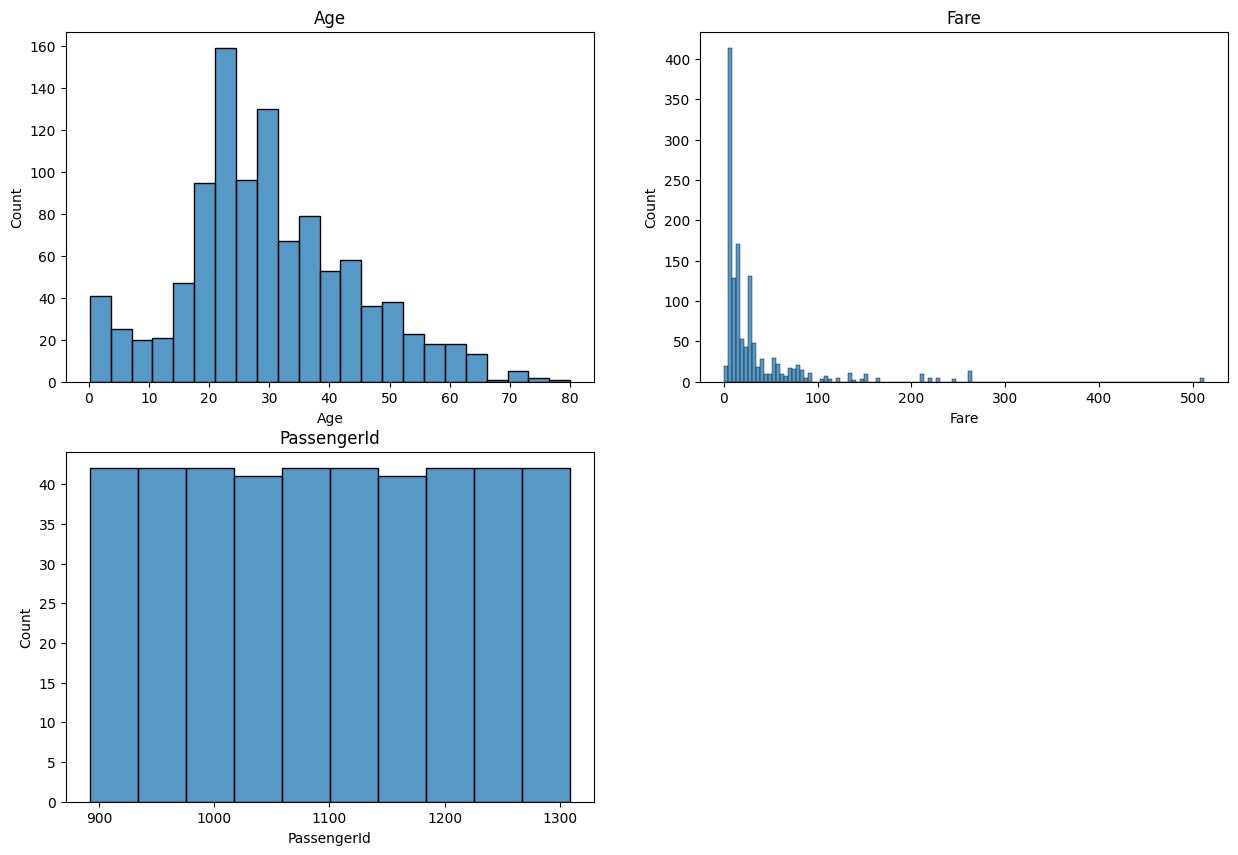

In [7]:
fig = plt.figure(figsize = (15, 10))
num_plots = len(continuous_numerical_features) 
rows = num_plots // 2 + 1 

for index, col in enumerate(continuous_numerical_features):
    plt.subplot(2, 2, index + 1)
    sns.histplot(numerical_features[col].dropna(), kde=False)
    plt.title(col)

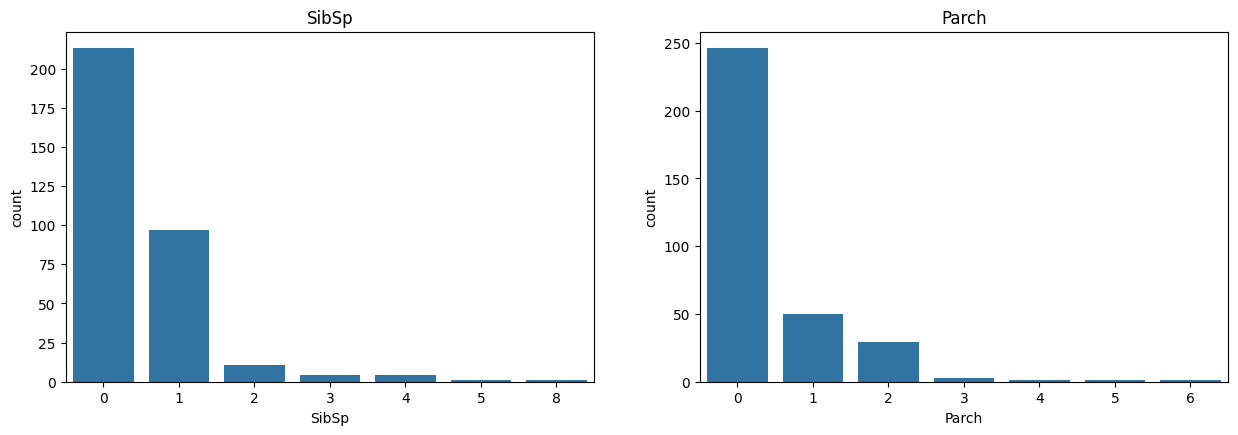

In [8]:
fig = plt.figure(figsize = (15, 10))
num_plots = len(discrete_features)

for index, col in enumerate(discrete_features):
    plt.subplot(2, 2, index + 1)
    sns.countplot(x = col, data = numerical_features.dropna())
    plt.title(col)


# Categorical Features 

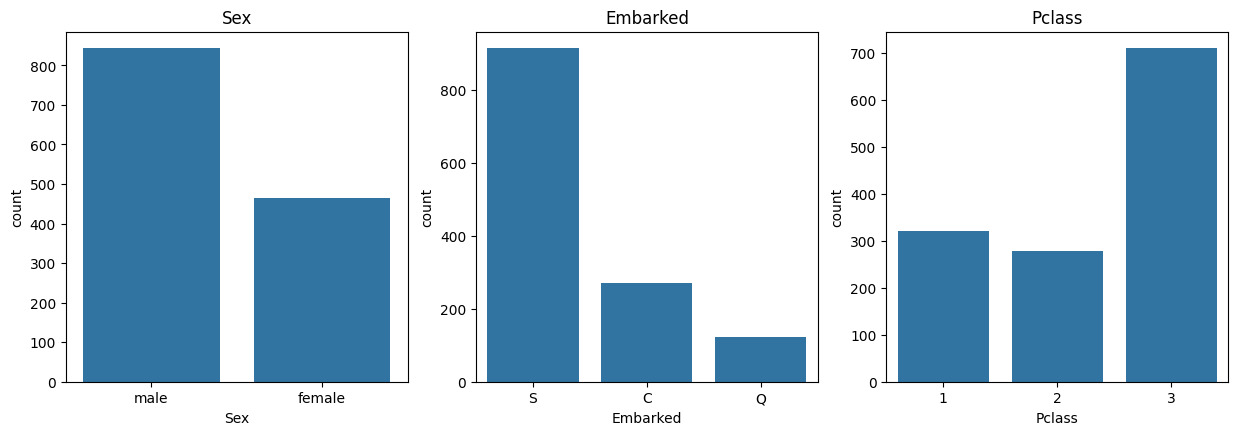

In [9]:
fig = plt.figure(figsize = (15, 10))
num_plots = len(categorical_features.columns)
cols = 3
rows = num_plots // cols + 1

for index, col in enumerate(categorical_features.columns):
    plt.subplot(rows, cols, index + 1)
    sns.countplot(x = col, data = categorical_features.dropna())
    plt.title(col)

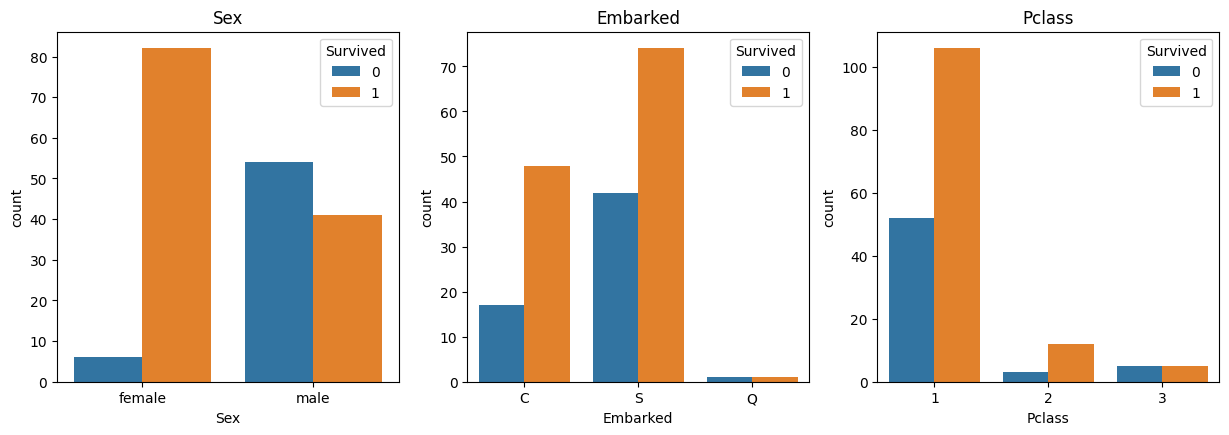

In [10]:
fig = plt.figure(figsize = (15, 10))
num_plots = len(categorical_features.columns)
cols = 3
rows = num_plots // cols + 1

for index, col in enumerate(categorical_features.columns):
    plt.subplot(rows, cols, index + 1)
    sns.countplot(x = col, data = data.dropna(), hue = "Survived")
    plt.title(col)

# Analyse bi-variée

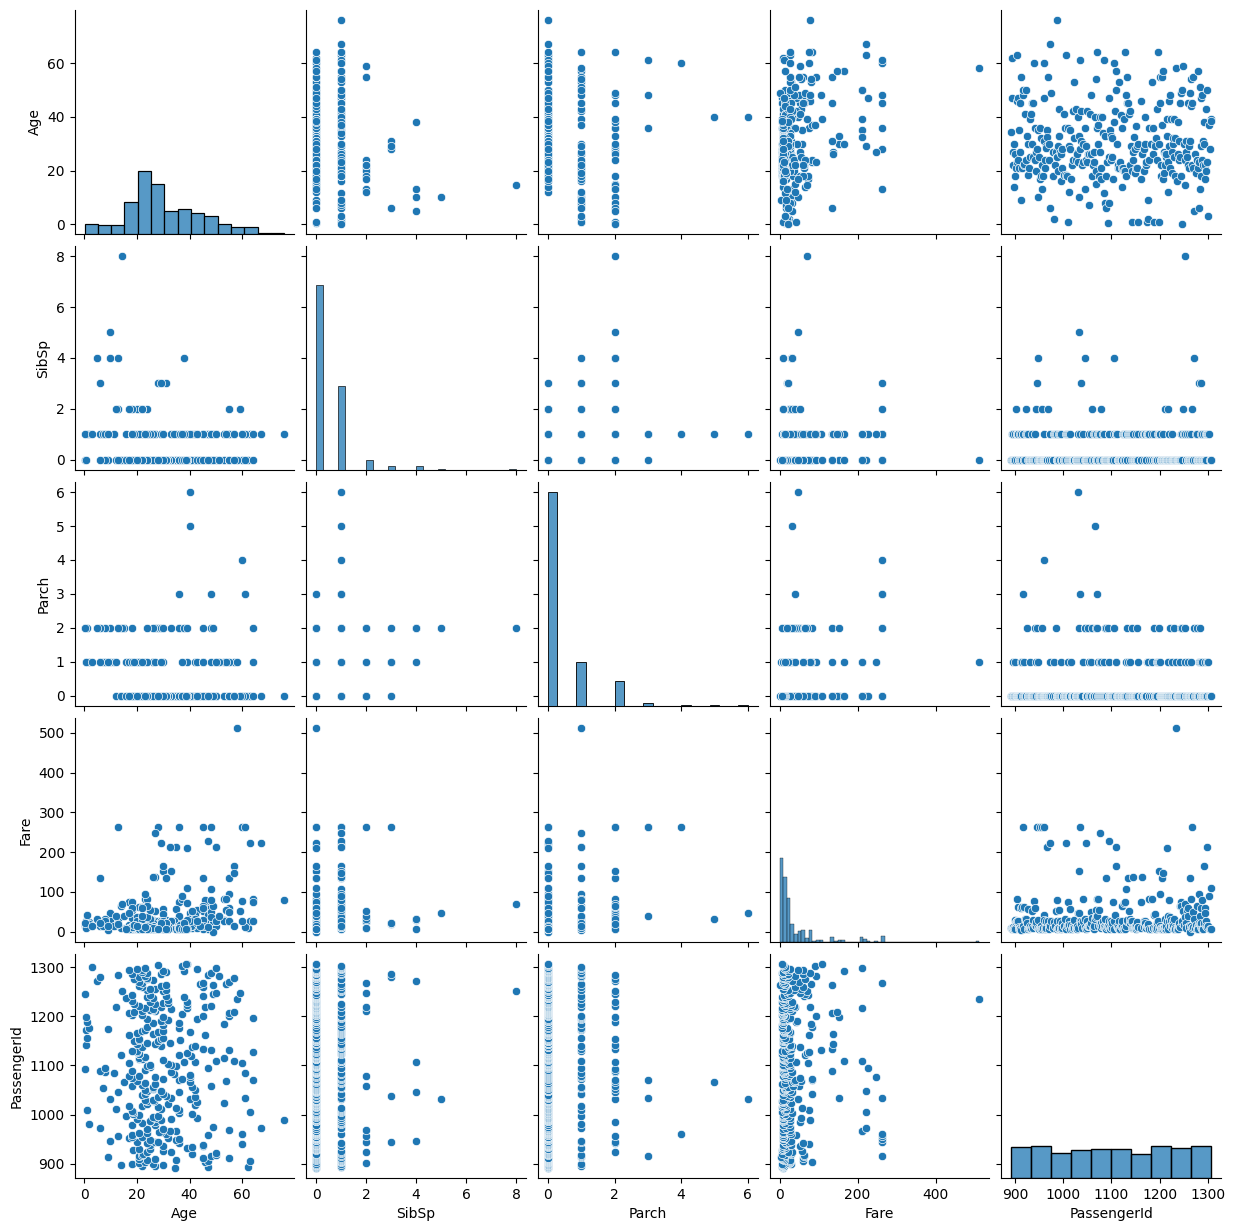

In [11]:
pairplot_data = numerical_features.copy()
sns.pairplot(pairplot_data.dropna())

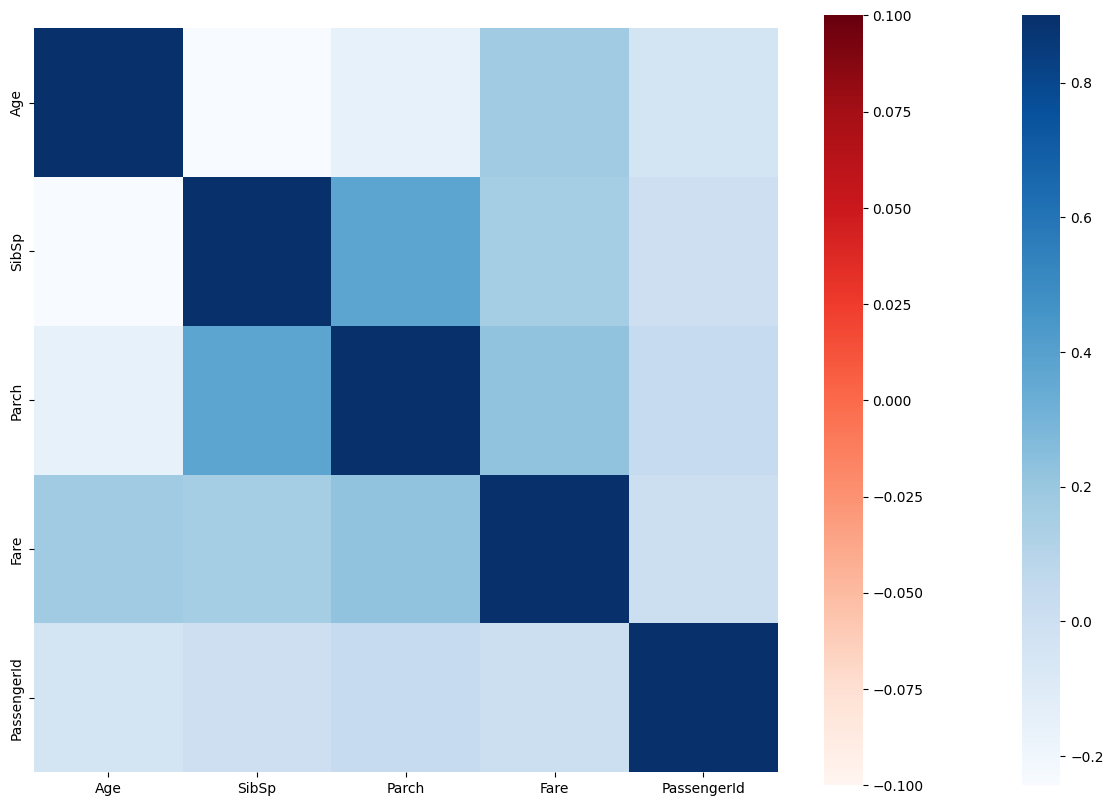

In [12]:
#correlation matrix 
corr = numerical_features.corr()    

masked_corr = corr.mask(np.abs(corr) <= 0.7)* corr.mask(np.abs(corr) >= 1)

fig, ax = plt.subplots(figsize = (15, 10))

sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True, ax=ax)
sns.heatmap(masked_corr, cmap="Reds", annot=True, fmt=".2f", mask=masked_corr.isnull(), square=True, ax=ax)
plt.show()

<Axes: xlabel='Survived', ylabel='Count'>

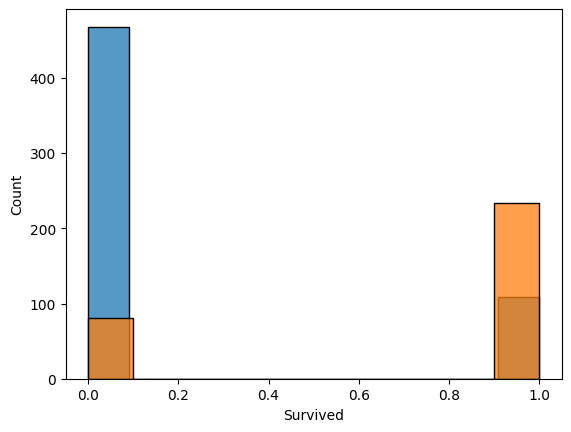

In [13]:
#group by the survived column
grouped = data[data.Sex == "male"]
sns.histplot(grouped["Survived"], kde=False)

#group by the survived column
grouped = data[data.Sex == "female"]
sns.histplot(grouped["Survived"], kde=False)


In [14]:
data.groupby("Sex")["Age"].median()

Sex
female    27.0
male      29.0
Name: Age, dtype: float64

# Data Cleaning

Deal with NaN

<Axes: title={'center': 'missing features'}, xlabel='features', ylabel='sum'>

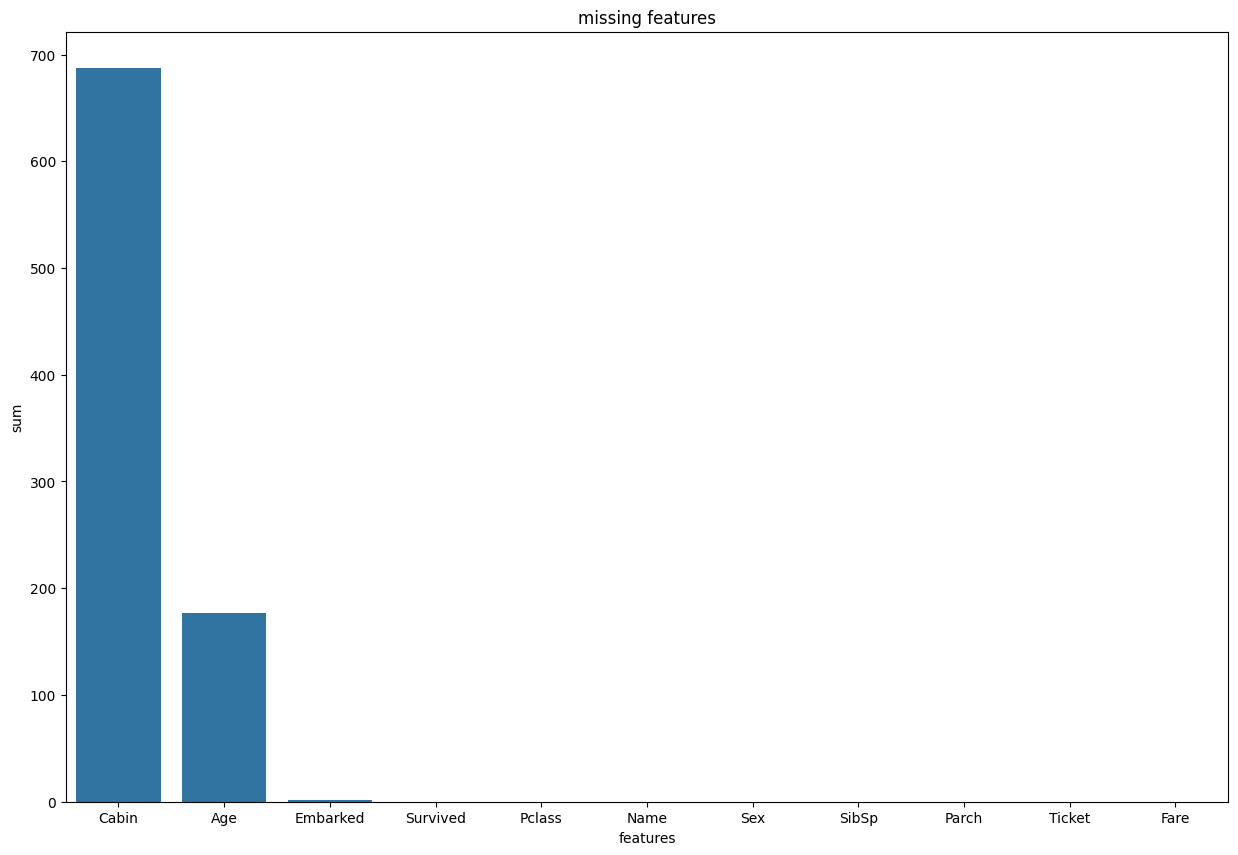

In [15]:
plt.figure(figsize = (15, 10))
plt.title("missing features")
missing_count = pd.DataFrame(data.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)

In [16]:
data.drop("Cabin", axis = 1, inplace = True)
test.drop("Cabin", axis = 1, inplace = True)

# AGE / Embarked

In [17]:
#filling age missing values with mean depending on the sex
data["Age"] =  data["Age"].fillna(data.groupby("Sex")["Age"].transform("mean"))


In [18]:
data["Age"]

0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
         ...    
886    27.000000
887    19.000000
888    27.915709
889    26.000000
890    32.000000
Name: Age, Length: 891, dtype: float64

In [19]:
data.groupby("Sex")["Age"].mean()

Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

In [20]:
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])

# Outliers

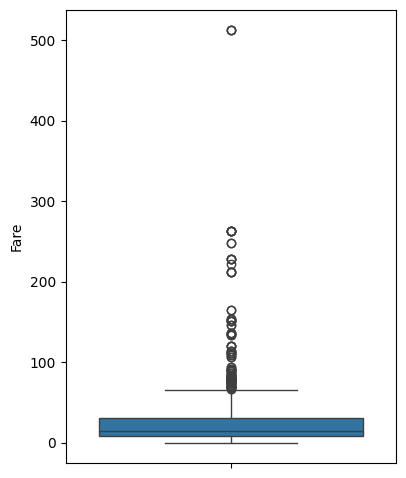

In [21]:
out_col = ["Fare"]
fig = plt.figure(figsize=(20,5))
plt.subplot(1,5,index+1)
sns.boxplot(y=out_col[0], data=data)
fig.tight_layout(pad=1.5)

<Axes: ylabel='Fare'>

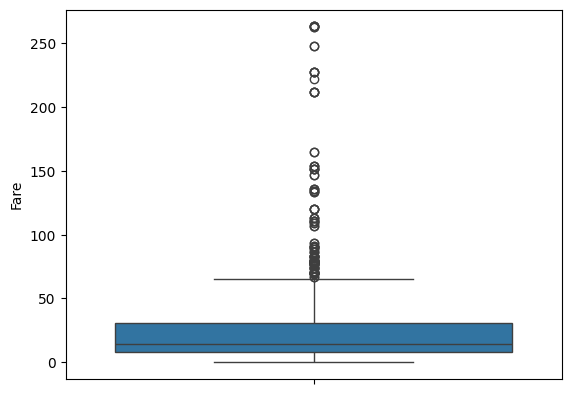

In [22]:
index_to_drop = data[data.Fare > 300].index
data.drop(index_to_drop, inplace = True)
sns.boxplot(y="Fare", data=data)


# Mapping features

# Feature Engineering

In [23]:
#Noble = data["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
#Noble.unique()
#data["Noble"] = Noble
#sns.countplot(x = "Noble", data = data, hue="Survived")


In [24]:
categorical_features = data.select_dtypes(include = ["object"]).columns
numerical_features = data.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

df_train_num = data[numerical_features]
df_train_cat = data[categorical_features].drop(["Name", "Ticket"], axis = 1)

# Find most important features relative to target
print("Find most important features relative to target")
corr = np.abs(df_train_num.corr())
corr.sort_values(["Survived"], ascending = False, inplace = True)
corr.Survived.head(11)

Numerical features : 6
Categorical features : 4
Find most important features relative to target


Survived    1.000000
Pclass      0.334068
Fare        0.261742
Age         0.082545
Parch       0.082157
SibSp       0.033395
Name: Survived, dtype: float64

Get Dummies for all categorical features

In [25]:
df_train_cat = pd.get_dummies(df_train_cat)
df_train_cat.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,False,True,False,False,True
1,True,False,True,False,False
2,True,False,False,False,True
3,True,False,False,False,True
4,False,True,False,False,True


# Modeling

In [26]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [27]:
X.columns
X.drop(["Name", "Ticket", "PassengerId", "Cabin"], axis = 1, inplace = True)

In [28]:
X.isna().sum()
X["Age"] =  X["Age"].fillna(data.groupby("Sex")["Age"].transform("mean"))

In [29]:
X.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    2
dtype: int64

In [30]:
X["Fare"] =  X["Fare"].fillna(X.Fare.mean())
X["Embarked"] = X["Embarked"].fillna(X["Embarked"].mode()[0])

In [31]:
X.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [32]:
X = pd.get_dummies(X, drop_first = True, dtype=int)
X.describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,29.864758,0.498854,0.385027,33.295479,0.644003,0.093965,0.699771
std,0.837836,12.896773,1.041658,0.865560,51.738879,0.478997,0.291891,0.458533
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000
50%,3.000000,30.000000,0.000000,0.000000,14.454200,1.000000,0.000000,1.000000
75%,3.000000,35.000000,1.000000,0.000000,31.275000,1.000000,0.000000,1.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000


In [33]:
df_train = X[:len(y)]
df_test = X[len(y):]


# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size = 0.3, random_state = 111)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (623, 8)
X_test : (268, 8)
y_train : (623,)
y_test : (268,)


In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score,precision_score, f1_score, accuracy_score
numerical_features = ["Age", "SibSp", "Parch", "Fare"]

stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])
df_test.loc[:, numerical_features] = stdSc.transform(df_test.loc[:, numerical_features])

In [37]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

#print accuracy on test
print(accuracy_score(xgboost.predict(X_train), y_train))
print(accuracy_score(xgboost.predict(X_test), y_test))


0.9630818619582665
0.835820895522388


In [38]:
submit = pd.DataFrame(data=xgboost.predict(df_test), index=test.index+892)

In [39]:
submit.to_csv("first_submit.csv")

In [40]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', gamma=3)

svc.fit(X_train, y_train)

#print accuracy on test
print(1-np.abs(((svc.predict(X_train)) - y_train)).mean())
print(1-np.abs(((svc.predict(X_test) > 0.5) - y_test)).mean())

0.9004815409309791
0.7238805970149254


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

print(1-np.abs(((clf.predict(X_train)) - y_train)).mean())
print(1-np.abs(((clf.predict(X_test) > 0.5) - y_test)).mean())

0.8619582664526485
0.832089552238806


In [42]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

print(accuracy_score(clf.predict(X_train), y_train))
print(accuracy_score(clf.predict(X_test), y_test))

0.9823434991974318
0.753731343283582


In [43]:
#logisitc regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print(accuracy_score(logreg.predict(X_train), y_train))
print(accuracy_score(logreg.predict(X_test), y_test))



0.8009630818619583
0.7910447761194029


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score,precision_score, f1_score, accuracy_score

def model_evaluation(actual,pred):
    print('Recall:    ',recall_score(actual,pred).round(3),end='\n')
    print('Precision: ',precision_score(actual,pred).round(3),end='\n')
    print('Accuracy:  ',accuracy_score(actual,pred).round(3),end='\n')
    print('F1 score:  ',f1_score(actual,pred).round(3),end='\n')
    
    cm = confusion_matrix(actual,pred)
    ConfusionMatrixDisplay(cm).plot()

xgb_clf = XGBClassifier()

cv_params = {
    'max_depth':[2,4,6],
    'min_child_weight':[.01,.04,.1,.3],
    'learning_rate':[.01,.03,.05,.09,.2],
    'n_estimators':[50,75,100,125]    
}

xgb_cv = GridSearchCV(xgb_clf,param_grid=cv_params,scoring=['precision','recall','f1','accuracy'],refit='accuracy',cv=5)
xgb_cv.fit(X_train,y_train)
pred = xgb_cv.best_estimator_.predict(X_test)

In [47]:
print(accuracy_score(logreg.predict(X_train), y_train))
print(accuracy_score(logreg.predict(X_test), y_test))

0.8009630818619583
0.7910447761194029
